In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline
# Create our portfolio of equities
tickers = ['AAPL','FB', 'C', 'DIS']
 
# Set the investment weights (I arbitrarily picked for example)
weights = np.array([.25, .3, .15, .3])
 
# Set an initial investment level
initial_investment = 1000000
 
# Download closing prices
data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())['Close']
 
#From the closing prices, calculate periodic returns
returns = data.pct_change()

returns.tail()

C:\Users\Diogo\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Symbols,AAPL,FB,C,DIS
Date,,,,
2020-05-12,-0.011428,-0.014448,-0.039029,-0.029786
2020-05-13,-0.012074,-0.023798,-0.041322,-0.015685
2020-05-14,0.006143,0.008337,0.035961,0.029052
2020-05-15,-0.005912,0.019680,-0.003329,0.029648
2020-05-18,0.023561,0.010954,0.089456,0.071527


In [2]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix

Symbols,AAPL,FB,C,DIS
Symbols,,,,
AAPL,0.000469,0.000316,0.000379,0.000258
FB,0.000316,0.000564,0.000341,0.000227
C,0.000379,0.000341,0.000717,0.000384
DIS,0.000258,0.000227,0.000384,0.000409


In [3]:
# Calculate mean returns for each stock
avg_rets = returns.mean()
 
# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
 # https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.
port_mean = avg_rets.dot(weights)
 
# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
 
# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment
             
# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

In [4]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

In [5]:
#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

30438.897089233273

1 day VaR @ 95% confidence: 30438.9
2 day VaR @ 95% confidence: 43047.1
3 day VaR @ 95% confidence: 52721.72
4 day VaR @ 95% confidence: 60877.79
5 day VaR @ 95% confidence: 68063.44
6 day VaR @ 95% confidence: 74559.77
7 day VaR @ 95% confidence: 80533.75
8 day VaR @ 95% confidence: 86094.2
9 day VaR @ 95% confidence: 91316.69
10 day VaR @ 95% confidence: 96256.24
11 day VaR @ 95% confidence: 100954.4
12 day VaR @ 95% confidence: 105443.43
13 day VaR @ 95% confidence: 109749.0
14 day VaR @ 95% confidence: 113891.92
15 day VaR @ 95% confidence: 117889.34


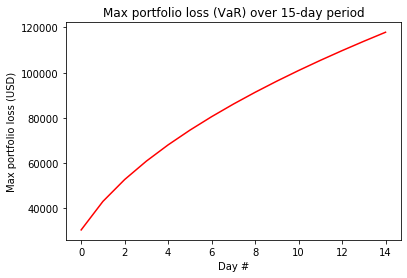

In [6]:
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

C:\Users\Diogo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


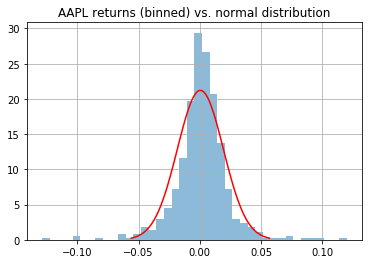

In [8]:
import matplotlib.mlab as mlab
import scipy
# Repeat for each equity in portfolio
returns['AAPL'].hist(bins=40, normed=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("AAPL returns (binned) vs. normal distribution")
plt.show()